In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [15]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    
    experiments = sorted(glob.glob(job.fn("experiments/*/*/traj_period-*.gsd")))

    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"experiments/max-shear-{max_shear}/temp-{temp}/stress-strain_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0:
            continue

        traj = gsd.hoomd.open(exper)

        stress = []
        shear = []

        for i in range(len(traj)):

            snap = traj[i] # initial state
            # print(snap.log)
            xy = snap.configuration.box[3]
            stress_xy = snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1]
            stress.append(stress_xy)
            shear.append(xy)
        dataset = pd.DataFrame({"strain": shear, "stress": stress})
        output[sp].append(dataset)

with open(project.fn("results/stress-strain_period-1000.pkl"), "wb") as f:
    pickle.dump(output, f)

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


In [41]:
len(traj)

800

In [36]:
len(output.keys())

48

In [62]:
def plot_stress_strain(shear, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    else:
        fig = axs.figure
    
    cmap = cm.inferno
    norm = colors.Normalize(vmin=0, vmax=.3)

    for k, v in output.items():
        if k.max_shear != shear:
            continue
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"

        # temp to idx mapping using
        temps = [0.0496, 0.0992, 0.1488, 0.1984]
        i = temps.index(k.temp)

        stress = np.mean([v_i["stress"].values for v_i in v], axis=0)[-40*5-1:]
        strain = np.mean([v_i["strain"].values for v_i in v], axis=0)[-40*5-1:]
        stress = np.array([np.mean(stress[i::40]) for i in range(41)])
        strain = np.array([np.mean(strain[i::40]) for i in range(41)])
        print(k, stress.shape, strain.shape)
        # frames = v[0]["frame"].values
        axs[i].plot(strain, stress, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}", alpha=1)
    for ax in axs:
        ax.set_ylabel("Stress", size="large")
        ax.set_xlabel("Strain", size="large")
        if legend:
            ax.legend(title="Temp Prep")
    fig.suptitle(f"Stress-strain; {shear} shear, 1000 period")

Statepoint(max_shear=0.01, period=1000.0, temp=0.0496, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.0992, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.1488, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.1984, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.0496, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.0992, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.1488, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.1984, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.0496, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.0992, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.1488, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.1984, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.049

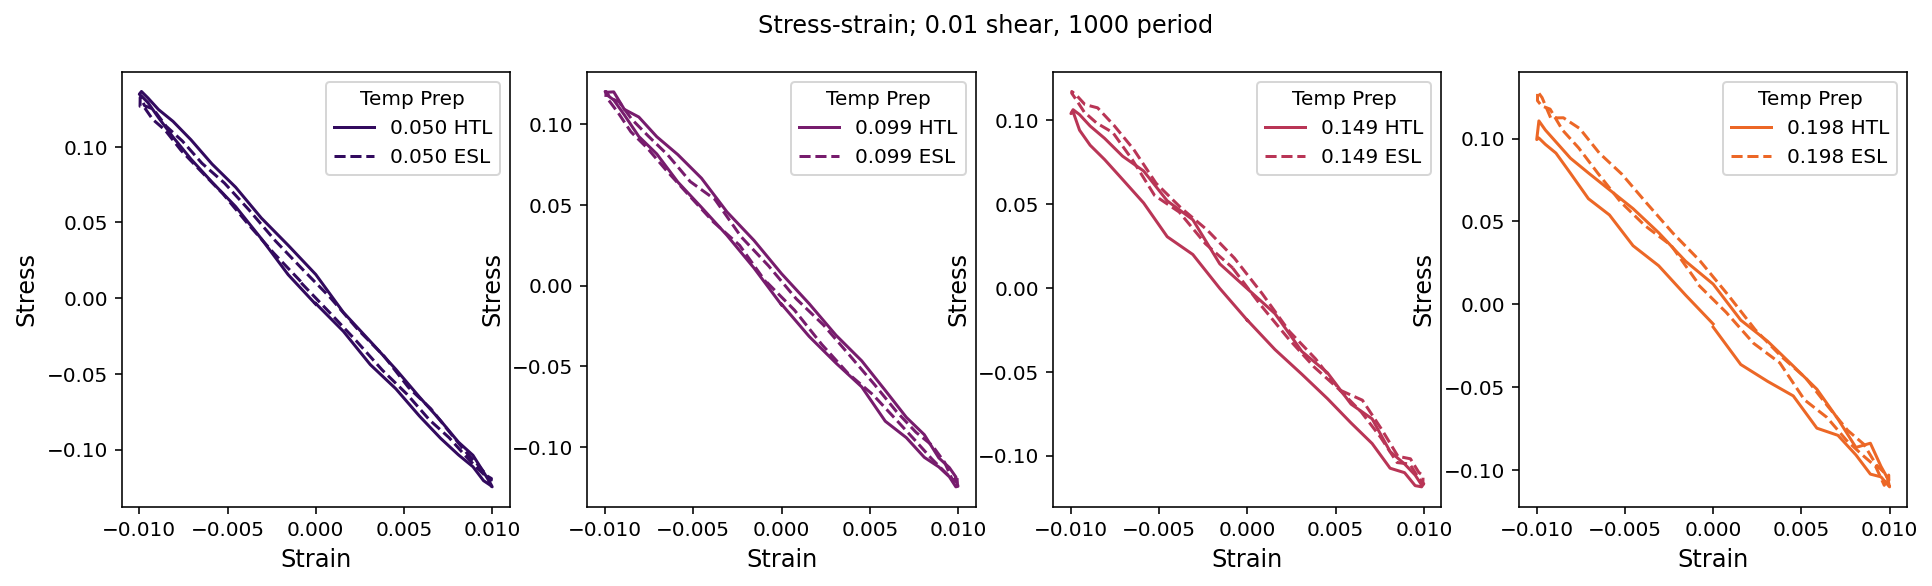

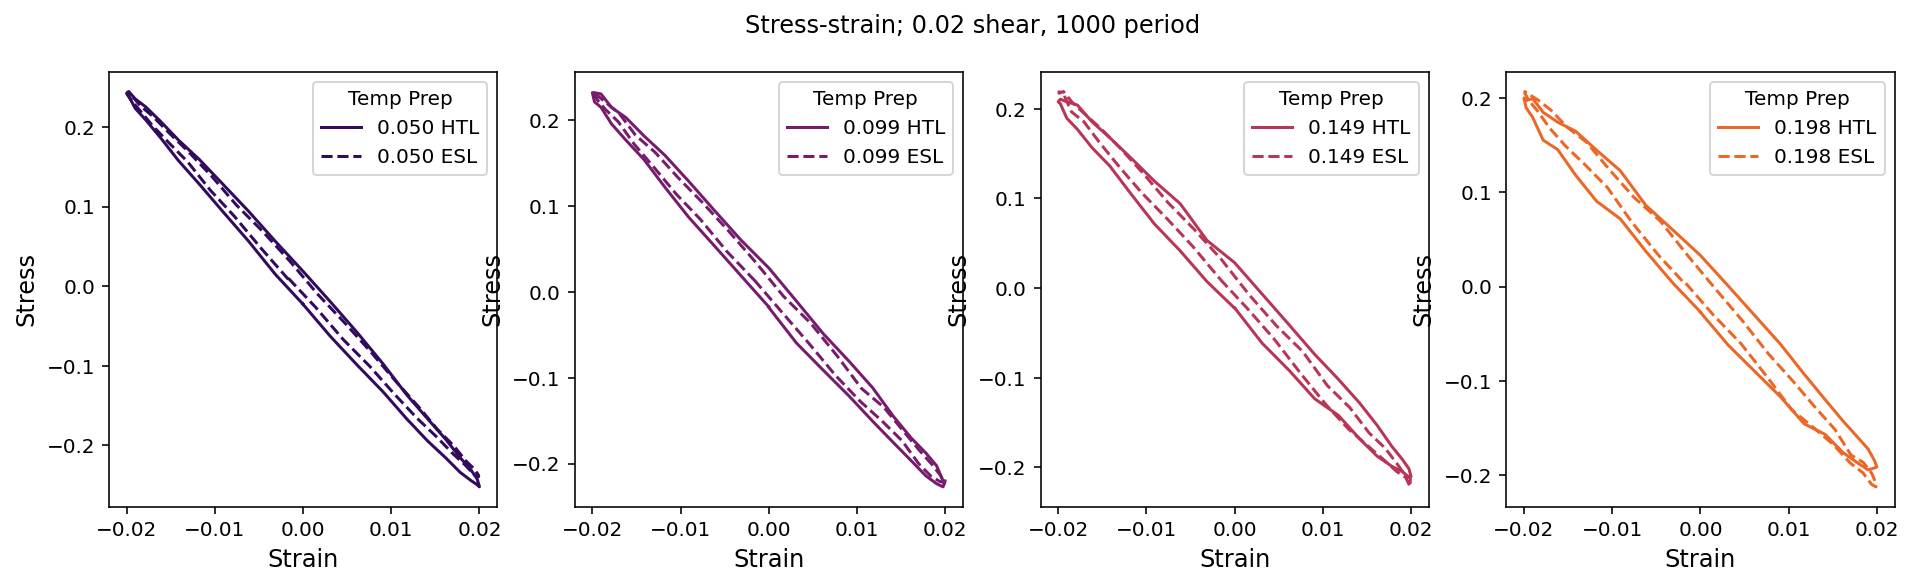

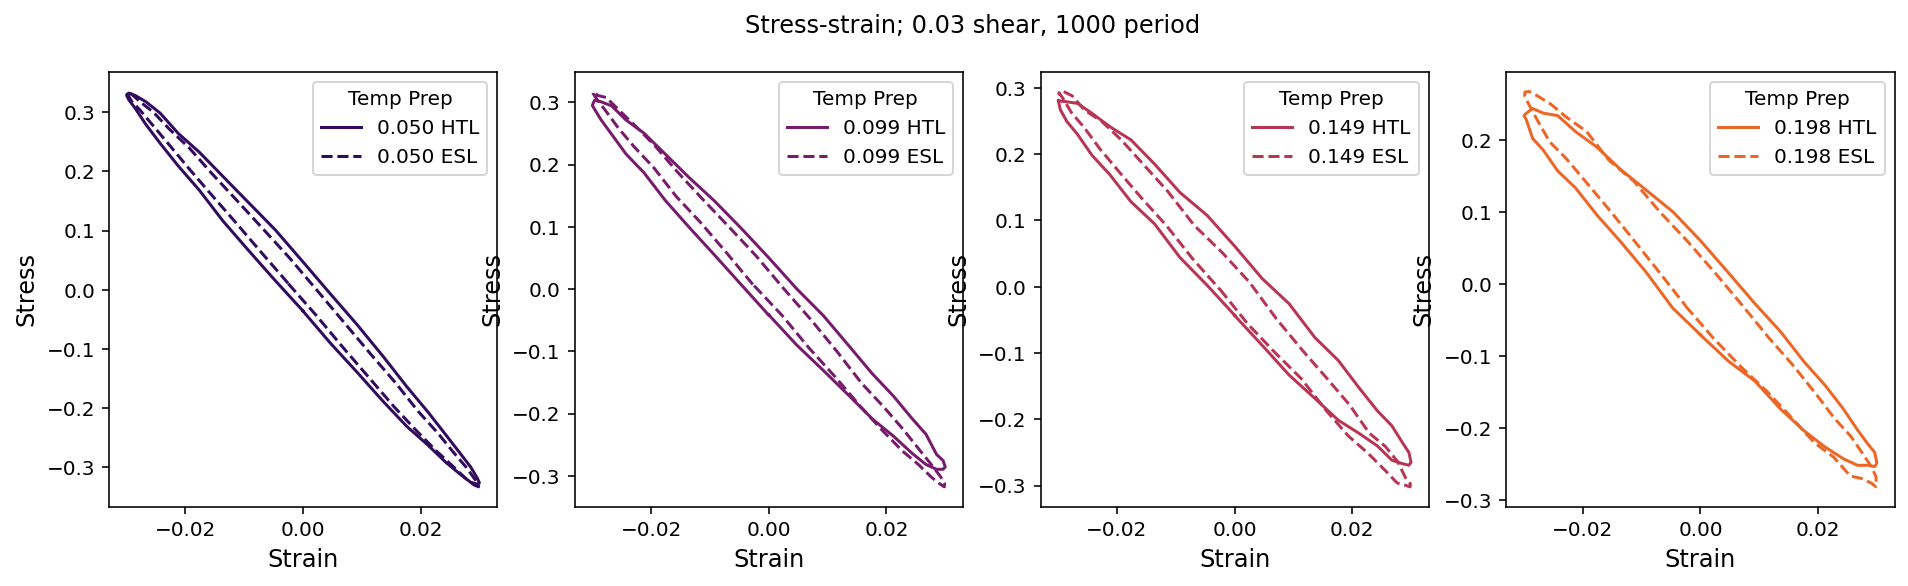

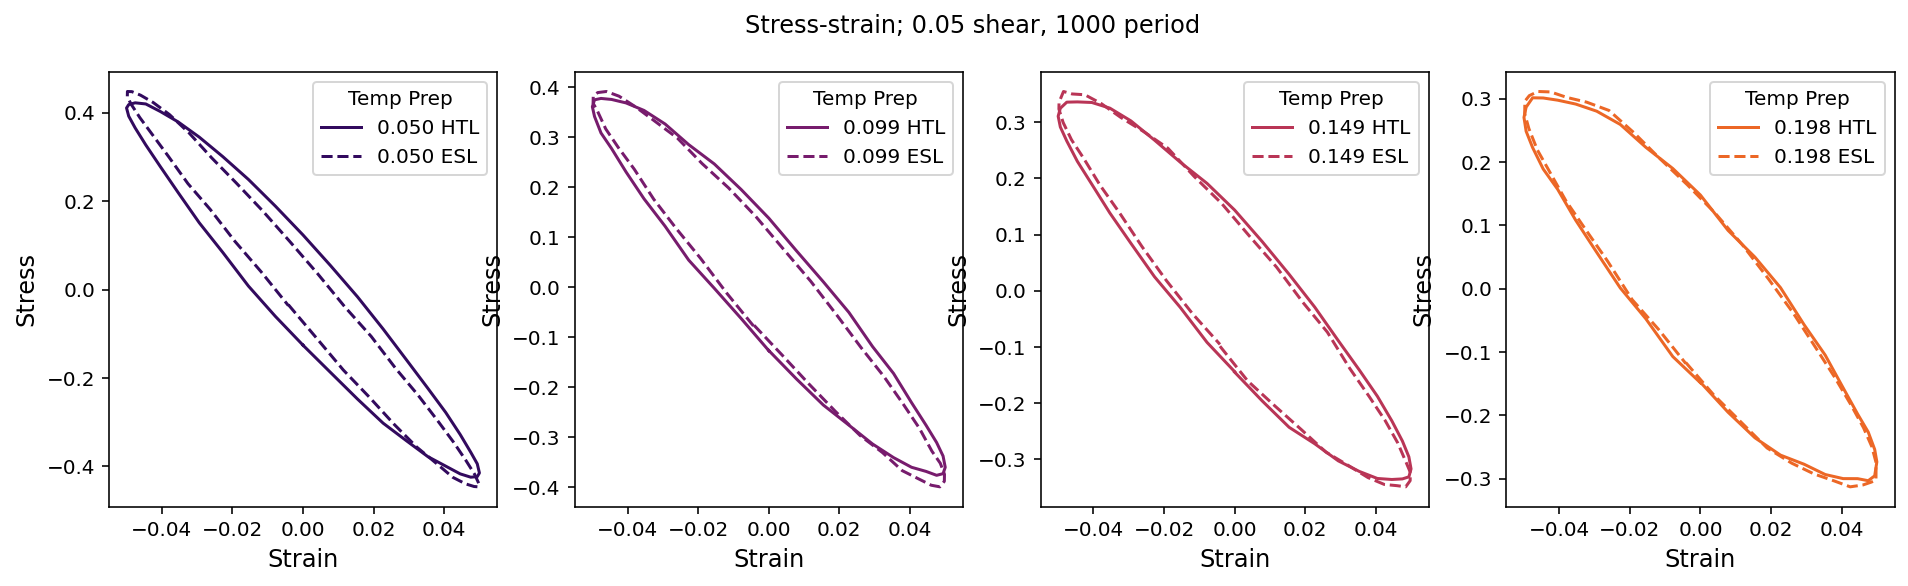

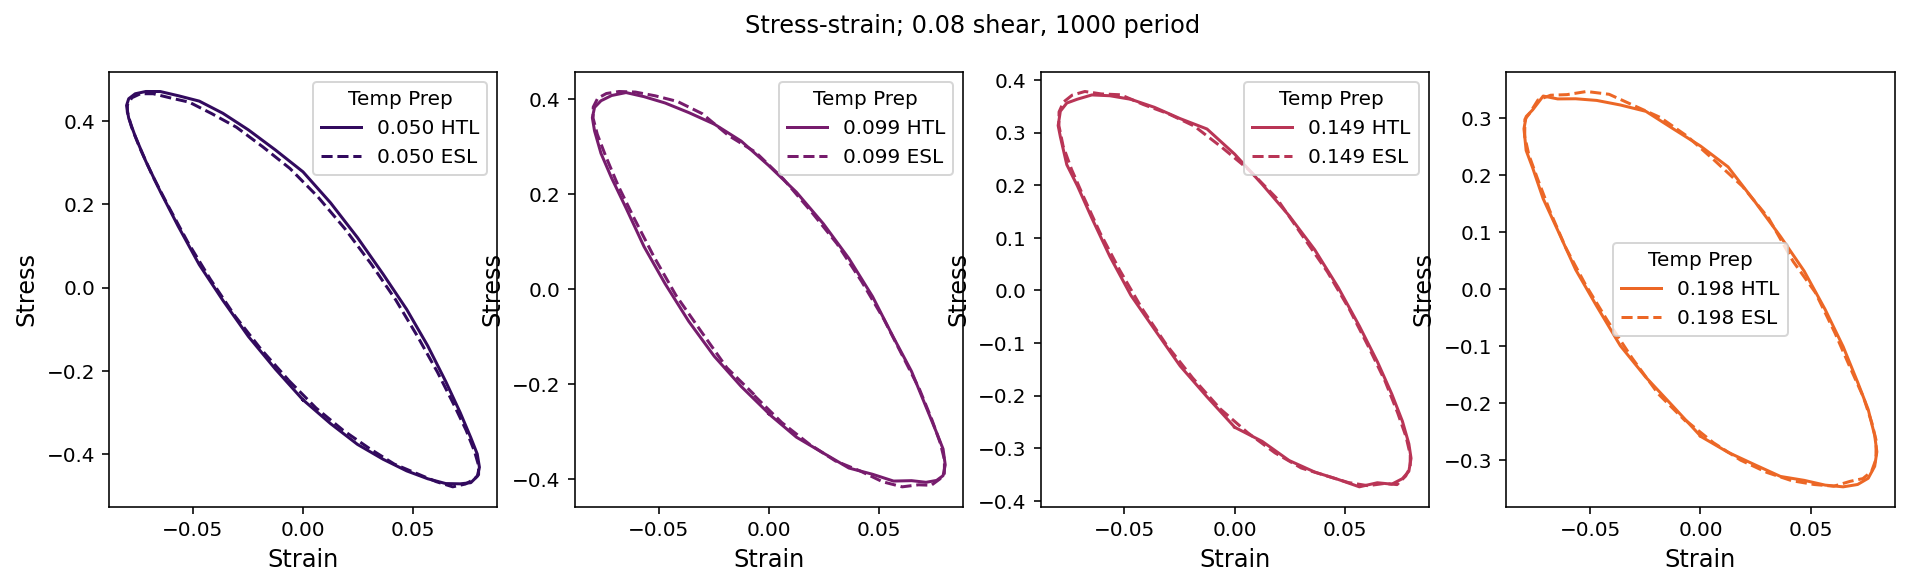

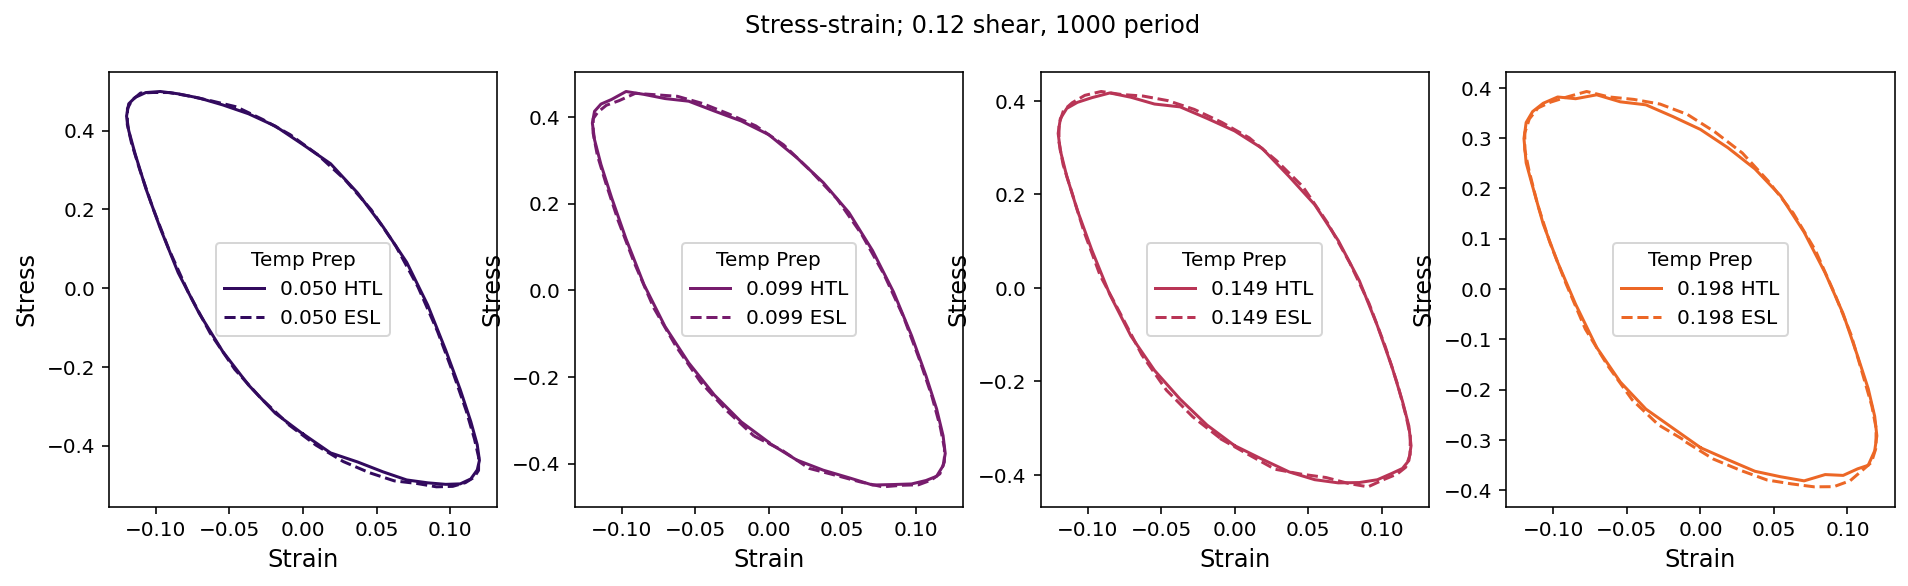

In [63]:
for shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plot_stress_strain(shear, legend=True)

In [70]:
def plot_stress_strain_transient(shear, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    else:
        fig = axs.figure
    
    cmap = cm.inferno
    norm = colors.Normalize(vmin=0, vmax=.3)

    for k, v in output.items():
        if k.max_shear != shear:
            continue
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = ":"

        # temp to idx mapping using
        temps = [0.0496, 0.0992, 0.1488, 0.1984]
        i = temps.index(k.temp)

        stress = np.mean([v_i["stress"].values for v_i in v], axis=0)[:40*5]
        strain = np.mean([v_i["strain"].values for v_i in v], axis=0)[:40*5]
        # frames = v[0]["frame"].values
        axs[i].plot(strain, stress, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}", alpha=1)
    for ax in axs:
        ax.set_ylabel("Stress", size="large")
        ax.set_xlabel("Strain", size="large")
        if legend:
            ax.legend(title="Temp Prep")
    fig.suptitle(f"Stress-strain; {shear} shear, 1000 period")

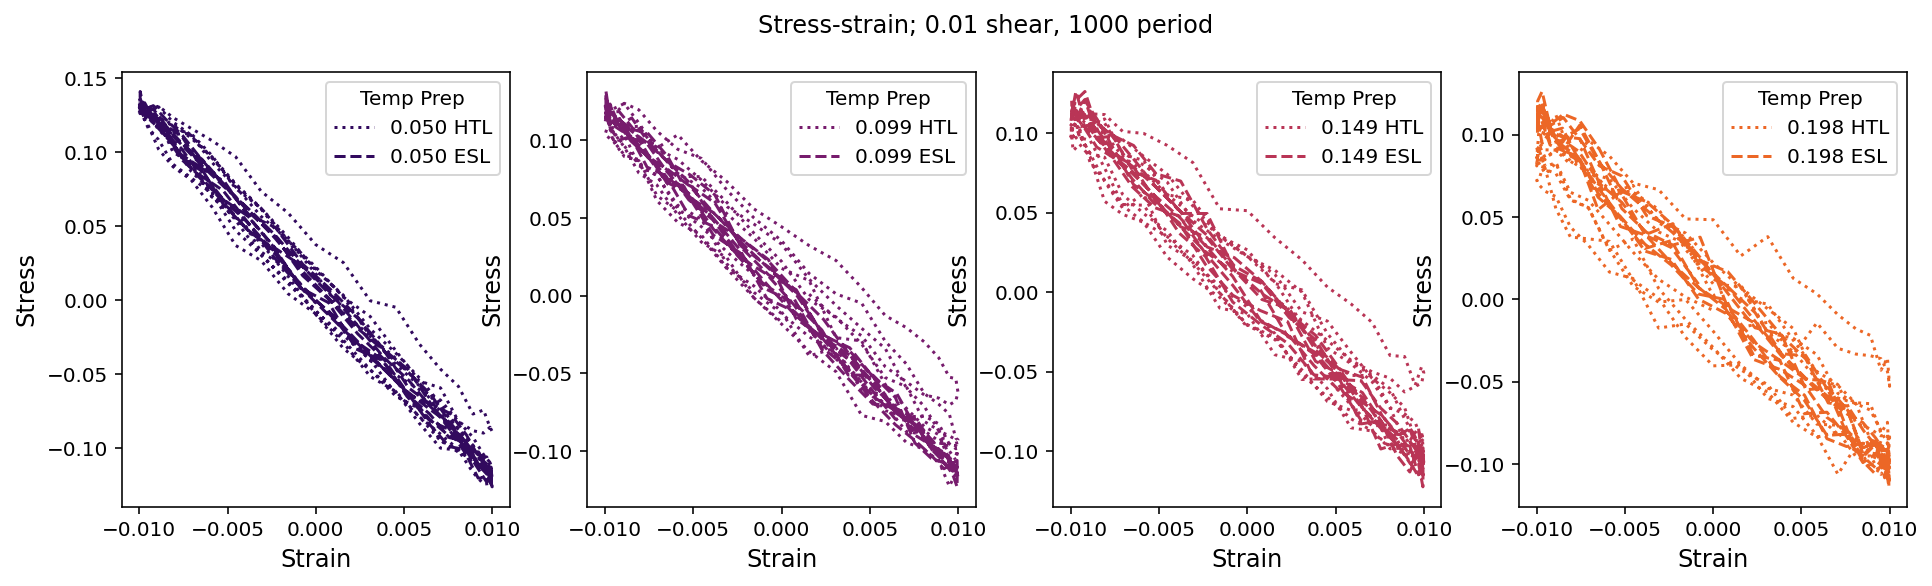

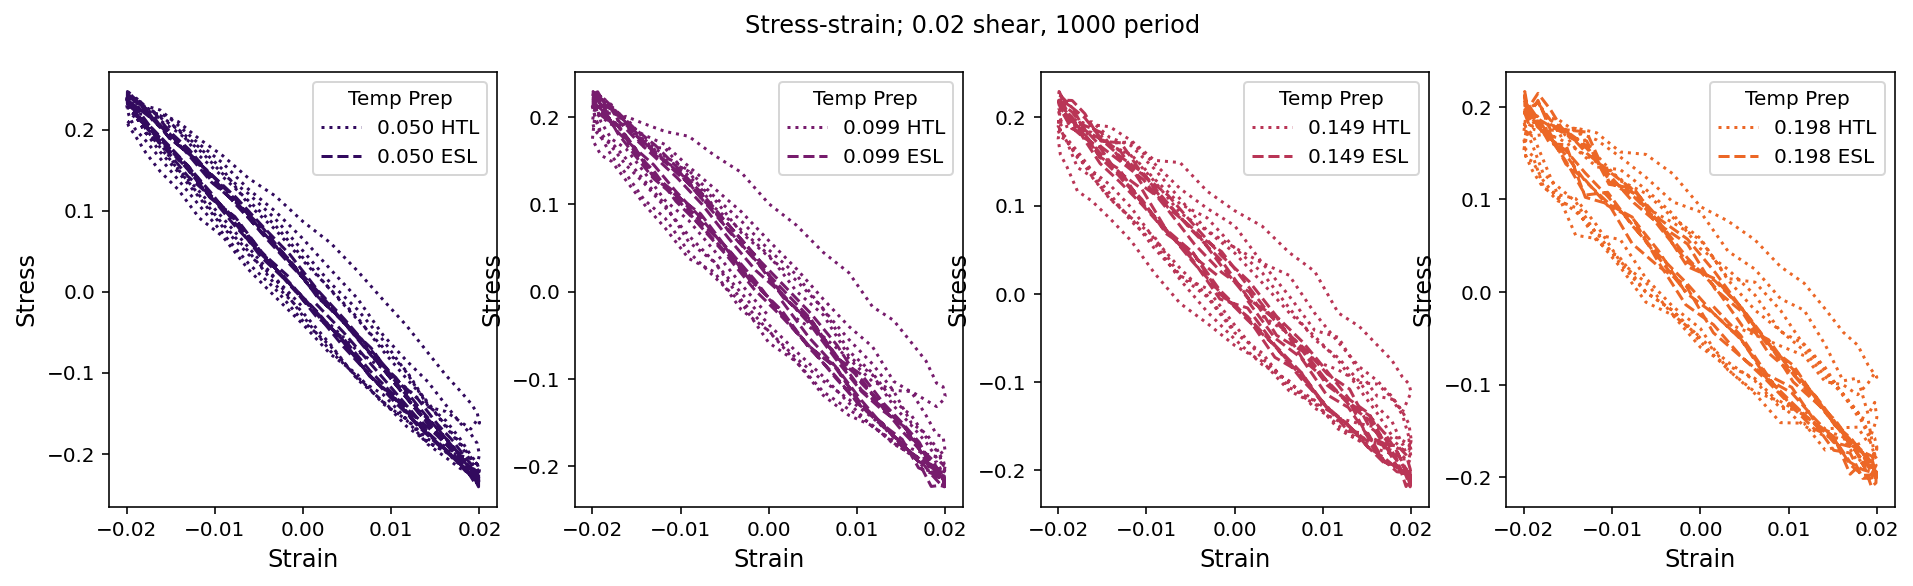

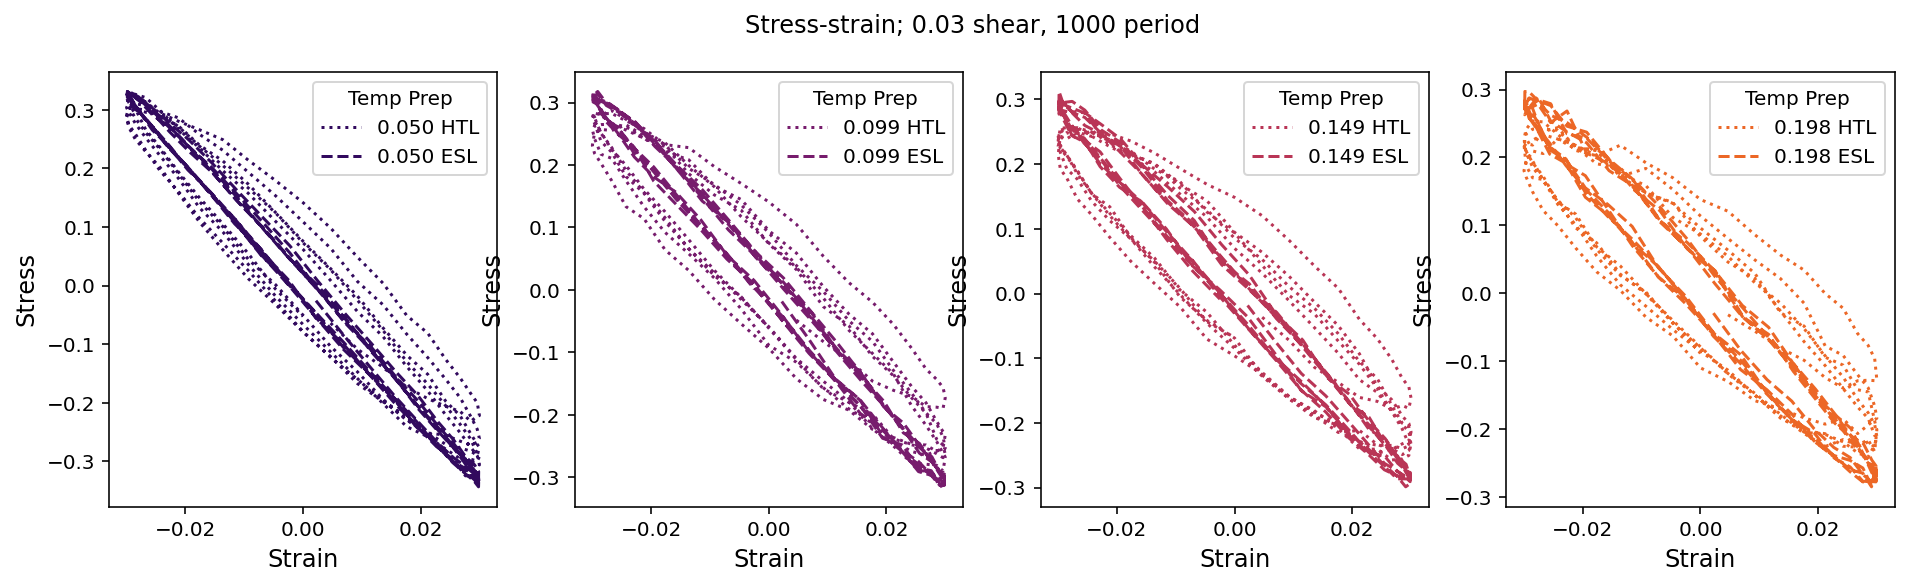

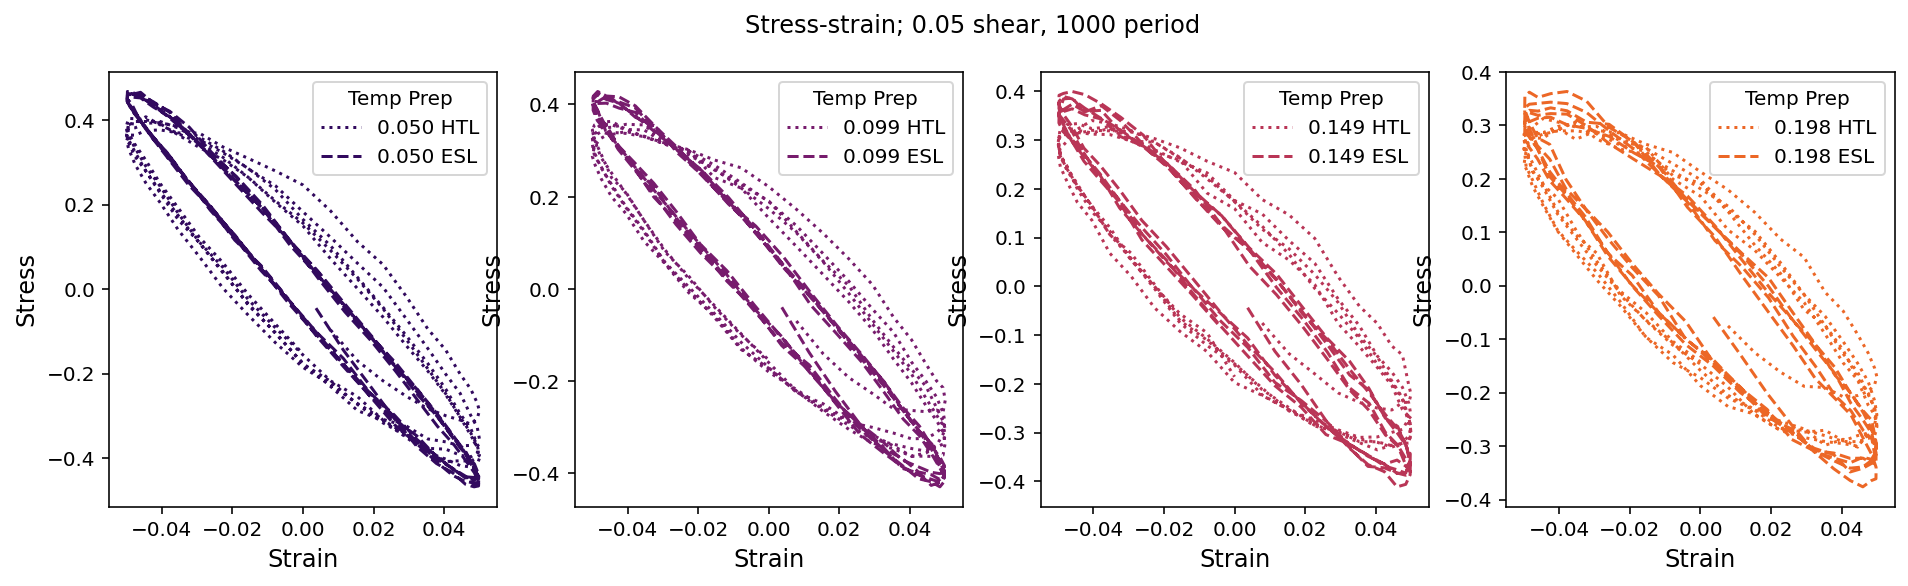

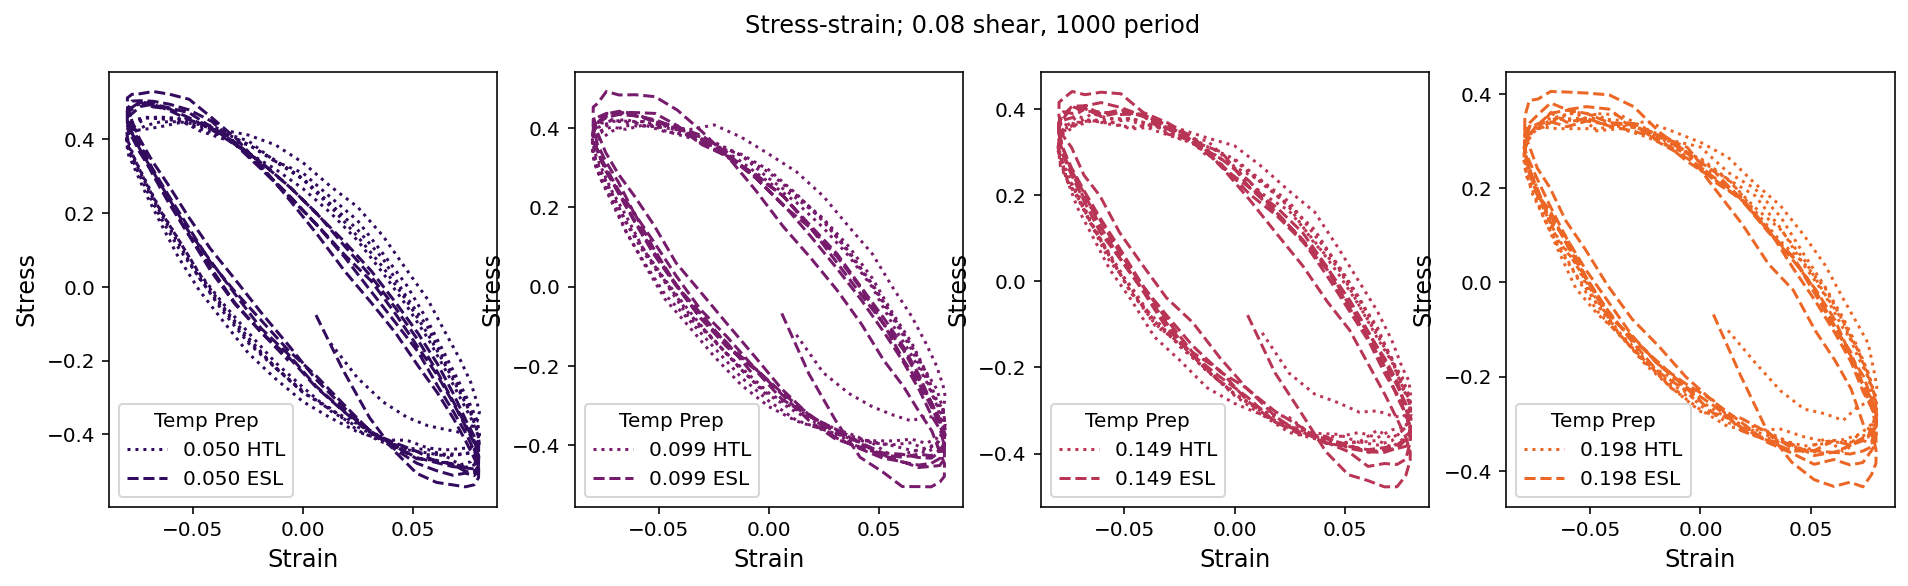

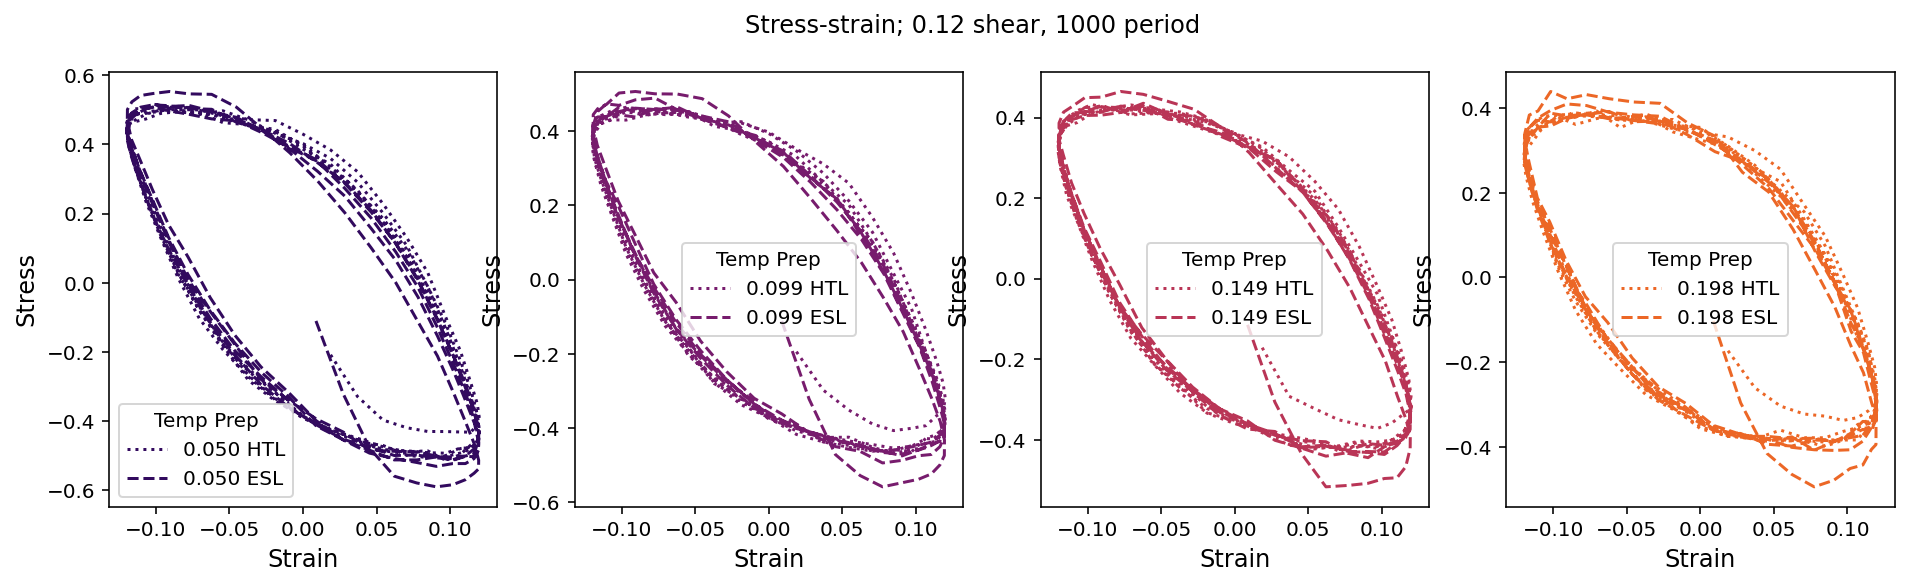

In [71]:
for shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plot_stress_strain_transient(shear, legend=True)